In [3]:
import numpy as np
from pprint import pprint

import sklearn.datasets
import sklearn.metrics
from sklearn.utils.multiclass import type_of_target
import autosklearn.classification

In [11]:
import openml
import autosklearn.classification
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np
import time

# ✅ Multi-label classification OpenML dataset IDs (should be multi-label!)
dataset_ids = [46763,40594,40591]  # replace with actual multi-label ones if needed
results = []

for openml_id in dataset_ids:
    print(f"\n🚀 Running Auto-Sklearn (Multi-Label) on Dataset {openml_id}")

    # ✅ Load dataset
    dataset = openml.datasets.get_dataset(openml_id)
    df, _, _, _ = dataset.get_data()

    target_cols = dataset.default_target_attribute.split(",")
    target_cols = [col.strip() for col in target_cols]

    X = df.drop(columns=target_cols)
    y = df[target_cols].astype(int)

    print(f"🧪 X shape: {X.shape}, y shape: {y.shape}")

    # ✅ Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    # ✅ AutoSklearn Classifier
    base_classifier = autosklearn.classification.AutoSklearnClassifier(
        # time_left_for_this_task=900,
        # per_run_time_limit=120,
                    time_left_for_this_task=60,
    per_run_time_limit=30,
        ensemble_kwargs={'ensemble_size': 20},
        n_jobs=-1,
        resampling_strategy='holdout',
        initial_configurations_via_metalearning=10,
    )

    model = MultiOutputClassifier(base_classifier)

    # ✅ Train
    start_time = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start_time

    # ✅ Predict
    y_pred = model.predict(X_test)

    # ✅ Metrics per target
    target_metrics = {}
    accuracies = []
    f1s = []

    for i, col in enumerate(y.columns):
        y_true = y_test.iloc[:, i]
        y_pred_col = y_pred[:, i]
        acc = accuracy_score(y_true, y_pred_col)
        f1 = f1_score(y_true, y_pred_col, zero_division=0)

        target_metrics[f"{col}_Accuracy"] = round(acc, 4)
        target_metrics[f"{col}_F1"] = round(f1, 4)

        accuracies.append(acc)
        f1s.append(f1)

    # ✅ Average metrics
    avg_acc = np.mean(accuracies)
    avg_f1 = np.mean(f1s)

    result_row = {
        "Dataset ID": openml_id,
        "AutoSklearn Avg Accuracy": round(avg_acc, 4),
        "AutoSklearn Avg F1": round(avg_f1, 4),
        "AutoSklearn Time (s)": round(fit_time, 2),
    }
    result_row.update(target_metrics)
    results.append(result_row)

    print(f"✅ Completed Dataset {openml_id} | Time: {fit_time:.2f}s")
    for k, v in target_metrics.items():
        print(f"  🔹 {k}: {v}")

# ✅ Save
results_df = pd.DataFrame(results)
results_df.to_csv("autosklearn_multilabel_results.csv", index=False)

print("\n📁 Results saved to 'autosklearn_multilabel_results.csv'")
print("🎉 Multi-Label Classification Completed!")



🚀 Running Auto-Sklearn (Multi-Label) on Dataset 46763
[WARNING] [2025-04-07 16:13:58,063:openml.datasets.functions] Could not download file from https://data.openml.org/datasets/0004/46763/dataset_46763.pq: Object at 'https://data.openml.org/datasets/0004/46763/dataset_46763.pq' does not exist.
[WARNING] [2025-04-07 16:13:59,047:root] Received uncompressed content from OpenML for https://api.openml.org/data/v1/download/22121479/football-player-position.arff.
🧪 X shape: (3611, 11), y shape: (3611, 1)
[WARNING] [2025-04-07 16:14:00,179:Client-AutoML(1):501b3525-13cb-11f0-bdbe-cfecfce40a72] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.


ValueError: Target is multiclass but average='binary'. Please choose another average setting, one of [None, 'micro', 'macro', 'weighted'].

In [13]:
import openml
import autosklearn.classification
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, f1_score
import pandas as pd
import numpy as np
import time
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# ✅ Multi-label classification OpenML dataset IDs
dataset_ids = [ 40594, 46763,40591]
results = []

for openml_id in dataset_ids:
    print(f"\n🚀 Running Auto-Sklearn (Multi-Label) on Dataset {openml_id}")

    # ✅ Load dataset
    dataset = openml.datasets.get_dataset(openml_id)
    df, _, _, _ = dataset.get_data()

    target_cols = dataset.default_target_attribute.split(",")
    target_cols = [col.strip() for col in target_cols]

    X = df.drop(columns=target_cols)
    y = df[target_cols].astype(int)

    print(f"🧪 X shape: {X.shape}, y shape: {y.shape}")

    # ✅ Preprocessing for X
    categorical_cols = X.select_dtypes(include=["object", "category"]).columns
    numeric_cols = X.select_dtypes(include=["number", "bool"]).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", SimpleImputer(strategy="mean"), numeric_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", sparse=False), categorical_cols),
        ]
    )


    # ✅ Apply preprocessing
    X_processed = preprocessor.fit_transform(X)
    print(f"✅ Processed X shape: {X_processed.shape}")

    # ✅ Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.33, random_state=42)

    # ✅ AutoSklearn Classifier
    base_classifier = autosklearn.classification.AutoSklearnClassifier(
        # time_left_for_this_task=900,
        # per_run_time_limit=120,
            time_left_for_this_task=60,
    per_run_time_limit=30,
        ensemble_kwargs={'ensemble_size': 20},
        n_jobs=-1,
        resampling_strategy='holdout',
        initial_configurations_via_metalearning=10,
    )

    model = MultiOutputClassifier(base_classifier)

    # ✅ Train
    start_time = time.time()
    model.fit(X_train, y_train)
    fit_time = time.time() - start_time

    # ✅ Predict
    y_pred = model.predict(X_test)

    # ✅ Metrics per target
    target_metrics = {}
    accuracies = []
    f1s = []

    for i, col in enumerate(y.columns):
        y_true = y_test.iloc[:, i]
        y_pred_col = y_pred[:, i]
        acc = accuracy_score(y_true, y_pred_col)
        f1 = f1_score(y_true, y_pred_col, average='macro', zero_division=0)

        target_metrics[f"{col}_Accuracy"] = round(acc, 4)
        target_metrics[f"{col}_F1"] = round(f1, 4)

        accuracies.append(acc)
        f1s.append(f1)

    # ✅ Average metrics
    avg_acc = np.mean(accuracies)
    avg_f1 = np.mean(f1s)

    result_row = {
        "Dataset ID": openml_id,
        "AutoSklearn Avg Accuracy": round(avg_acc, 4),
        "AutoSklearn Avg F1": round(avg_f1, 4),
        "Fit Time (s)": round(fit_time, 2),
    }
    result_row.update(target_metrics)
    results.append(result_row)

# ✅ Final Results
results_df = pd.DataFrame(results)
print("\n📊 Summary Results:")
print(results_df)



🚀 Running Auto-Sklearn (Multi-Label) on Dataset 40594
🧪 X shape: (2000, 243), y shape: (2000, 7)
✅ Processed X shape: (2000, 243)
[WARNING] [2025-04-07 16:28:45,023:Client-AutoML(1):5f635d1f-13cd-11f0-bdbe-cfecfce40a72] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.
[WARNING] [2025-04-07 16:29:49,231:Client-AutoML(1):85b00b86-13cd-11f0-bdbe-cfecfce40a72] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.
[WARNING] [2025-04-07 16:30:44,894:Client-AutoML(1):a7078371-13cd-11f0-bdbe-cfecfce40a72] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.
[WARNING] [2025-04-07 16:30:50,981:Client-EnsembleBuilder] No runs were available to build an ensemble from
[WARNING] [2025-04-07 16:31:45,231:Client-AutoML(1):cb1c6600-13cd-11f0-bdbe-cfecfce40a72] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.
[WARNING] [2025-04-07 16:32:40,440:Client

✅ Saved results to 'autosklearn_multi_label_results.csv'


/tmp/ipykernel_228798/737531439.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_names, y=f1_vals, palette="viridis")


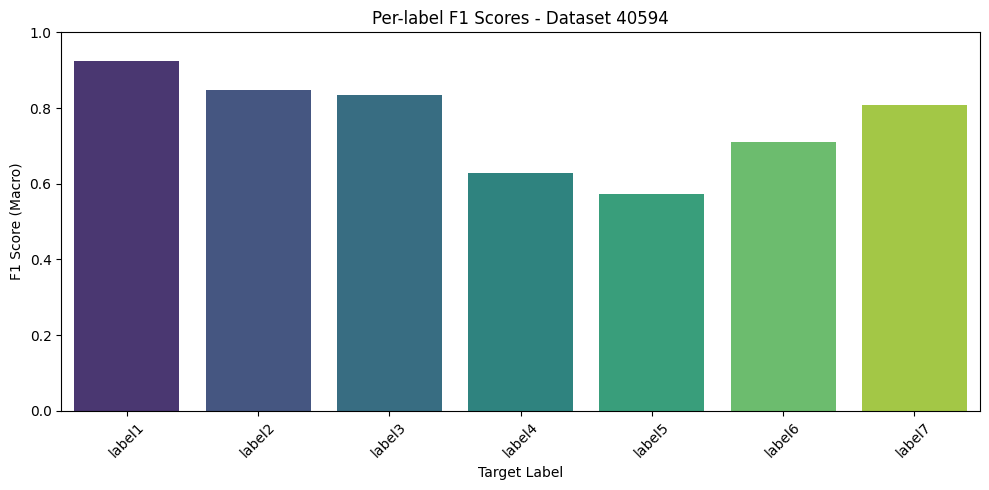

/tmp/ipykernel_228798/737531439.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_names, y=f1_vals, palette="viridis")


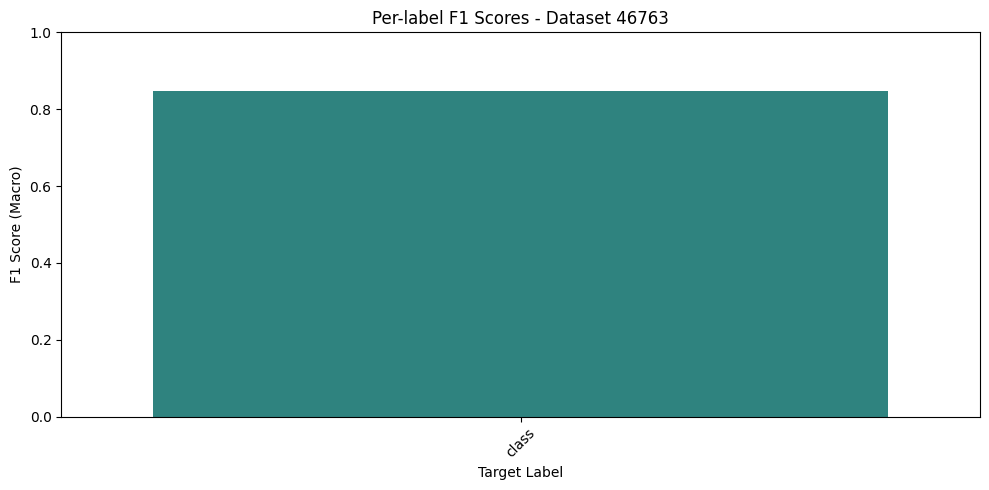

/tmp/ipykernel_228798/737531439.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_names, y=f1_vals, palette="viridis")


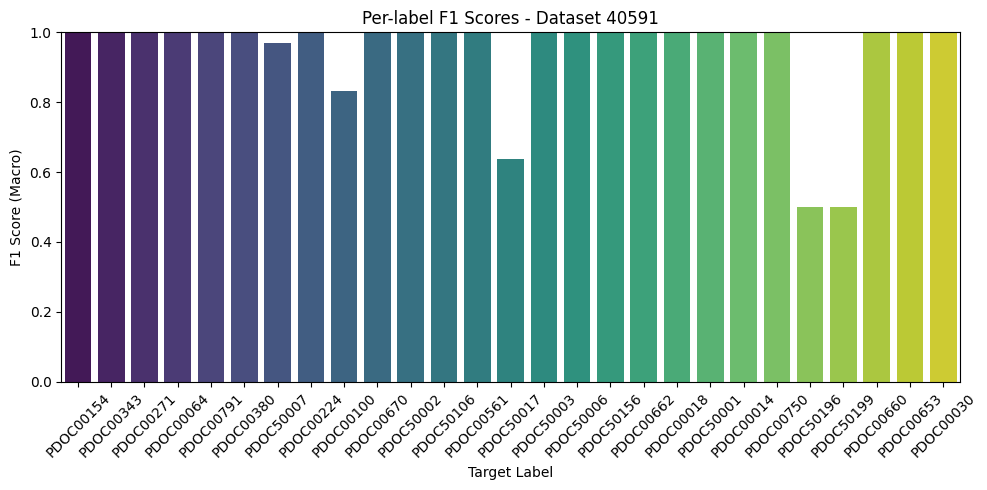

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 🔽 Save summary results to CSV
results_df.to_csv("autosklearn_multi_label_results.csv", index=False)
print("✅ Saved results to 'autosklearn_multi_label_results.csv'")

# 🔽 Create directory to save plots
os.makedirs("f1_plots", exist_ok=True)

# 🔽 Plot F1 scores per target column per dataset
for result in results:
    dataset_id = result["Dataset ID"]
    
    # Filter only F1 columns
    f1_scores = {k.replace("_F1", ""): v for k, v in result.items() if k.endswith("_F1")}
    label_names = list(f1_scores.keys())
    f1_vals = list(f1_scores.values())

    plt.figure(figsize=(10, 5))
    sns.barplot(x=label_names, y=f1_vals, palette="viridis")
    plt.title(f"Per-label F1 Scores - Dataset {dataset_id}")
    plt.xlabel("Target Label")
    plt.ylabel("F1 Score (Macro)")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save plot
    plt.savefig(f"f1_plots/f1_scores_dataset_{dataset_id}.png")
    plt.show()


In [3]:
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=60,
    per_run_time_limit=30,
    # Bellow two flags are provided to speed up calculations
    # Not recommended for a real implementation
    initial_configurations_via_metalearning=0,
    smac_scenario_args={"runcount_limit": 1},
)
automl.fit(X_train, y_train, dataset_name="reuters")

[WARNING] [2025-03-26 06:44:02,529:Client-AutoML(1):reuters] Capping the per_run_time_limit to 29.0 to have time for a least 2 models in each process.


AutoSklearnClassifier(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      initial_configurations_via_metalearning=0,
                      per_run_time_limit=30,
                      smac_scenario_args={'runcount_limit': 1},
                      time_left_for_this_task=60)

In [4]:
print(automl.leaderboard())


          rank  ensemble_weight           type      cost  duration
model_id                                                          
2            1              1.0  random_forest  0.447294  3.709628


In [5]:
pprint(automl.show_models(), indent=4)


{   2: {   'balancing': Balancing(random_state=1),
           'classifier': <autosklearn.pipeline.components.classification.ClassifierChoice object at 0x7f2b0342daf0>,
           'cost': 0.4472941828699525,
           'data_preprocessor': <autosklearn.pipeline.components.data_preprocessing.DataPreprocessorChoice object at 0x7f2b034d33d0>,
           'ensemble_weight': 1.0,
           'feature_preprocessor': <autosklearn.pipeline.components.feature_preprocessing.FeaturePreprocessorChoice object at 0x7f2b0342da30>,
           'model_id': 2,
           'rank': 1,
           'sklearn_classifier': RandomForestClassifier(max_features=15, n_estimators=512, n_jobs=1,
                       random_state=1, warm_start=True)}}


In [6]:
# Print statistics about the auto-sklearn run such as number of
# iterations, number of models failed with a time out.
print(automl.sprint_statistics())

auto-sklearn results:
  Dataset name: reuters
  Metric: f1_macro
  Best validation score: 0.552706
  Number of target algorithm runs: 1
  Number of successful target algorithm runs: 1
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 0
  Number of target algorithms that exceeded the memory limit: 0



In [20]:
# openml.datasets.get_dataset(41463)
X, y = sklearn.datasets.fetch_openml(data_id=40594, return_X_y=True, as_frame=False)

In [15]:
openml.datasets.get_dataset(46763)


OpenML Dataset
Name.........: football-player-position
Version......: 1
Format.......: arff
Upload Date..: 2025-03-14 15:53:30
Licence......: CC0
Download URL.: https://api.openml.org/data/v1/download/22121479/football-player-position.arff
OpenML URL...: https://www.openml.org/d/46763
# of features: None

In [22]:
openml.datasets.get_dataset(40594)


OpenML Dataset
Name.........: reuters
Version......: 2
Format.......: ARFF
Upload Date..: 2017-02-16 21:21:07
Licence......: Public
Download URL.: https://api.openml.org/data/v1/download/4644187/reuters.arff
OpenML URL...: https://www.openml.org/d/40594
# of features: None

In [5]:
openml.datasets.get_dataset(40591)

OpenML Dataset
Name.........: genbase
Version......: 2
Format.......: ARFF
Upload Date..: 2017-02-16 21:19:52
Licence......: Public
Download URL.: https://api.openml.org/data/v1/download/4644184/genbase.arff
OpenML URL...: https://www.openml.org/d/40591
# of features: None